In [374]:
# Imports
import numpy as np
import pandas as pd
import glob
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

## Step 1 - Data Preprocessing

In [286]:
class RNASequences:
    """The rna counts and annotations of the samples. 

    Attributes:
        __rna_counts: A dataframe containing all the rna counts. Each row
            represents a sample and each column a gene.
        __annotations: A dataframe containing all samples annotations. Each row
            represents a sample and each column an annotation.
        __samples: The concatenation of __rna_counts and __annotations. Contains
            all the informations about each sample.
        __als_counts: A sub dataframe of __rna_counts containing all the samples
            of the "ALS Spectrum MND" group.
        __other_counts: A sub dataframe of __rna_counts containing all the samples
            of the "Other Neurological Disorders" group.
        __control_counts: A sub dataframe of __rna_counts containing all the samples
            of the "Non-Neurological Control group.
        __group_names: A list of string = ["ALS", "Other", "Control"]
    """

    def __init__(self, data_dir="Data/"):
        """Initializes the instance based on the data directory.

        Args:
          data_dir: The directory where the data is located.
        """
        # RNA Counts
        filenames = glob.glob("*.txt", root_dir=data_dir)
        dfs = []

        for filename in filenames:
            df = pd.read_csv(data_dir + filename,
                             sep="\t",
                             names=[filename[:10]],
                             skiprows=1).T
            dfs.append(df)
        
        self.__rna_counts = pd.concat(dfs)
        self.__remove_zeros()

        # Sample Annotations
        self.__annotations = pd.DataFrame(columns=["Subject ID",
                                                   "Sample Group",
                                                   "CNS Subregion"])
        tree = ET.parse(open("Data/GSE124439_family.xml"))
        root = tree.getroot()
        namespace = {"ns": "http://www.ncbi.nlm.nih.gov/geo/info/MINiML"}

        for sample in root.findall("ns:Sample", namespace):
            sample_id = sample.attrib["iid"]
            for channel in sample.iterfind(".//ns:Channel", namespace):
                self.__annotations.loc[sample_id] = [
                    channel[4].text.strip(),
                    channel[5].text.strip(),
                    channel[3].text.strip(),
                ]
        
        self.__check_annotations()

        self.__samples = pd.concat([self.__rna_counts, self.__annotations], axis=1)
        self.__als_counts = self.__get_group_counts("ALS Spectrum MND")
        self.__other_counts = self.__get_group_counts("Other Neurological Disorders")
        self.__control_counts = self.__get_group_counts("Non-Neurological Control")
        self.__group_names = ["ALS", "Other", "Control"]

    def __remove_zeros(self):
        """Removes columns with only zeros."""
        self.__rna_counts = (
            self.__rna_counts
            .loc[:, (self.__rna_counts != 0).any(axis=0)])
    
    def __check_annotations(self):
        """Checks if all the samples have annotations.

        Raises:
            AssertionError: If the indexes of __rna_counts and __annotations
                are different.
        """
        assert (
            self.__rna_counts
            .index
            .difference(self.__annotations.index)
            .empty
        )
    
    def __get_group_counts(self, group):
        """Returns the rna counts of the specified group.

        Args:
            group: A string representing the name of the group.
        """
        samples = self.__annotations[self.__annotations["Sample Group"] == group].index
        return self.__rna_counts.loc[samples]

    def _ipython_display_(self):
        """Displays the samples."""
        display(self.__samples)
    
    def get_samples(self):
        """Returns the rna counts and annotations of all samples."""
        return self.__samples

    def get_rna_counts(self):
        """Returns the rna counts of all samples."""
        return self.__rna_counts
    
    def get_annotations(self):
        """Returns the annotations of all samples."""
        return self.__annotations
    
    def get_group_counts(self, group=None):
        """Returns the counts of a specified test group.

        If there is no specified group returns the counts of all samples.

        Args:
            group: If not None, a string representing the name of the group.
                Groups are : "ALS", "Control" and "Other".
        """
        match group:
            case "ALS":
                return self.__als_counts
            case "Other":
                return self.__other_counts
            case "Control":
                return self.__control_counts
            case _:
                return self.__rna_counts
    
    def get_group_names(self):
        return self.__group_names
    
    def individual_samples_count(self):
        """Returns the amount of individuals per sample count."""
        return self.__annotations["Subject ID"].value_counts().value_counts()
    
    def groups_size(self, cumulative=False):
        """Returns the amount of samples per group."""
        sizes = self.__annotations["Sample Group"].value_counts()
        return np.cumsum(sizes) if cumulative else sizes
    
    def regions_count(self):
        """Returns the amount of samples per region."""
        return self.__annotations["CNS Subregion"].value_counts()
    
    def plot_annotations(self):
        fig, axes = plt.subplots(1, 3, figsize=(20, 5))

        [individual, group, region] = axes
        counts = [self.individual_samples_count(), self.groups_size(), self.regions_count()]

        for i, count in enumerate(counts):
            count.rename(None).plot(
                ax=axes[i],
                kind="pie",
                autopct=(lambda i: '{:.0f}'.format(i*count.sum()/100)),
            )

        individual.set_title("Amount of individuals per sample count")
        group.set_title("Amount of samples per group")
        region.set_title("Amount of samples per region")
        fig.suptitle("Samples description", fontsize=20)

        plt.show()
        plt.close()

    def mean(self, group=None, by_sample=False, sort=False, rename=True):
        """Returns the mean of rna counts of a group.

        Args:
            group: A string representing the name of the group. 
            by_sample: If False, computes the mean for each gene across all samples.
                If True, computes the mean for each sample across all genes.
            sort: If True, sorts the returned dataframe.
            rename: If True, renames the only column of the returned dataframe to "Mean".
        
        Returns:
            A dataframe with a single row of the computed means. 
        """
        mean = self.get_group_counts(group).mean(axis=by_sample).to_frame()

        if sort:
            mean = mean.sort_values(by=0)
        if rename:
            mean.rename(columns={0: "Mean"}, inplace=True)
        return mean
        
    def median(self, group=None, by_sample=False, sort=False, rename=True):
        """Returns the median of rna counts of a group.

        Args:
            group: A string representing the name of the group. 
            by_sample: If False, computes the median for each gene across all samples.
                If True, computes the median for each sample across all genes.
            sort: If True, sorts the returned dataframe.
            rename: If True, renames the only column of the returned dataframe to "Median".
        
        Returns:
            A dataframe with a single row of the computed means. 
        """
        median = self.get_group_counts(group).median(axis=by_sample).to_frame()

        if sort:
            median = median.sort_values(by=0)
        if rename:
            median.rename(columns={0: "Median"}, inplace=True)
        return median
        
    def std(self, group=None, by_sample=False, sort=False, rename=True):
        """Returns the std of rna counts of a group.

        Args:
            group: A string representing the name of the group. 
            by_sample: If False, computes the std for each gene across all samples.
                If True, computes the std for each sample across all genes.
            sort: If True, sorts the returned dataframe.
            rename: If True, renames the only column of the returned dataframe to "Std".
        
        Returns:
            A dataframe with a single row of the computed means. 
        """
        std = self.get_group_counts(group).std(axis=by_sample).to_frame()

        if sort:
            std = std.sort_values(by=0)
        if rename:
            std.rename(columns={0: "Std"}, inplace=True)
        return std

    def plot_metrics(self, by_sample=False, log=False):
        np.seterr(divide = "ignore")
        fig, axes = plt.subplots(1, 3, figsize=(20, 5))
        [mean, median, std] = axes

        groups = self.get_group_names()
        for group in groups:
            (self.mean(group=group, by_sample=by_sample, sort=True)
             .apply(lambda x: np.log10(x) if log else x)
             .plot(ax=mean))
            (self.median(group=group, by_sample=by_sample, sort=True)
             .apply(lambda x: np.log10(x) if log else x)
             .plot(ax=median))
            (self.std(group=group, by_sample=by_sample, sort=True)
             .apply(lambda x: np.log10(x) if log else x)
             .plot(ax=std))

        for axe in axes:
            if by_sample:
                x_label = "Samples"
                stop = max(self.groups_size())
                x_tick_labels = np.linspace(start=0, stop=stop, num=10, dtype=int)
                title = "Mean, median & std of each sample across all genes"
            else:
                x_label = "Genes"
                stop = len(self.get_rna_counts().columns)
                x_tick_labels = np.linspace(start=0, stop=stop, num=8, dtype=int)
                title = "Mean, median & std of each gene across all samples"
            
            axe.set_xlabel(x_label, fontsize=15)
            axe.set_xticks(x_tick_labels)
            axe.set_xticklabels(x_tick_labels)
            axe.legend(groups)
            fig.suptitle(title + " (log)" if log else title, fontsize=20)

        mean.set_ylabel("Mean", fontsize=15)
        median.set_ylabel("Median", fontsize=15)
        std.set_ylabel("Std", fontsize=15)

        plt.show()
        plt.close()
        np.seterr(divide = "warn")

    def plot_rsd(self):
        fig, ax = plt.subplots(1, 1, figsize=(15, 5))
        
        groups = self.get_group_names()
        for group in groups:
            mean = self.mean(group=group, rename=False)
            std = self.std(group=group, rename=False)
            rsd = std.div(mean).sort_values(by=0).rename(columns={0: "RSD"}).apply(lambda x: np.log10(x))
            rsd.plot(ax=ax)

        ax.set_xlabel("Genes", fontsize=15)
        
        stop = len(self.get_rna_counts().columns)
        x_tick_labels = np.linspace(start=0, stop=stop, num=15, dtype=int)
        ax.set_xticks(x_tick_labels)
        ax.set_xticklabels(x_tick_labels)
        ax.legend(groups)
        ax.set_ylabel("RSD", fontsize=15)
        fig.suptitle("Relative Standard Deviation of each gene across all samples (log)", fontsize=20)

        plt.show()
        plt.close()


sequences = RNASequences()

In [ ]:
samples = sequences.get_samples()
samples.sample(n=5)

## Step 2 - Descriptive analysis

### Samples description

In [251]:
annotations = sequences.get_annotations()
annotations.sample(n=10)

,Subject ID,Sample Group,CNS Subregion
GSM3533275,NEUFT454ZFP,ALS Spectrum MND,Motor Cortex (Lateral)
GSM3533309,NEUAT369TG5,ALS Spectrum MND,Motor Cortex (Lateral)
GSM3533398,NEULN488RD5,ALS Spectrum MND,Frontal Cortex
GSM3533294,NEUUE532LFF,ALS Spectrum MND,Motor Cortex (Lateral)
GSM3533317,NEUGV399KJW,ALS Spectrum MND,Motor Cortex (Medial)
GSM3533328,NEUMT947ALA,ALS Spectrum MND,Motor Cortex (Lateral)
GSM3533381,PF-UCL-1,Non-Neurological Control,Frontal Cortex
GSM3533342,NEUDG727NTW,ALS Spectrum MND,Motor Cortex (Lateral)
GSM3533287,NEUCW292DYJ,ALS Spectrum MND,Frontal Cortex
GSM3533388,PF-UCL-46,ALS Spectrum MND,Frontal Cortex


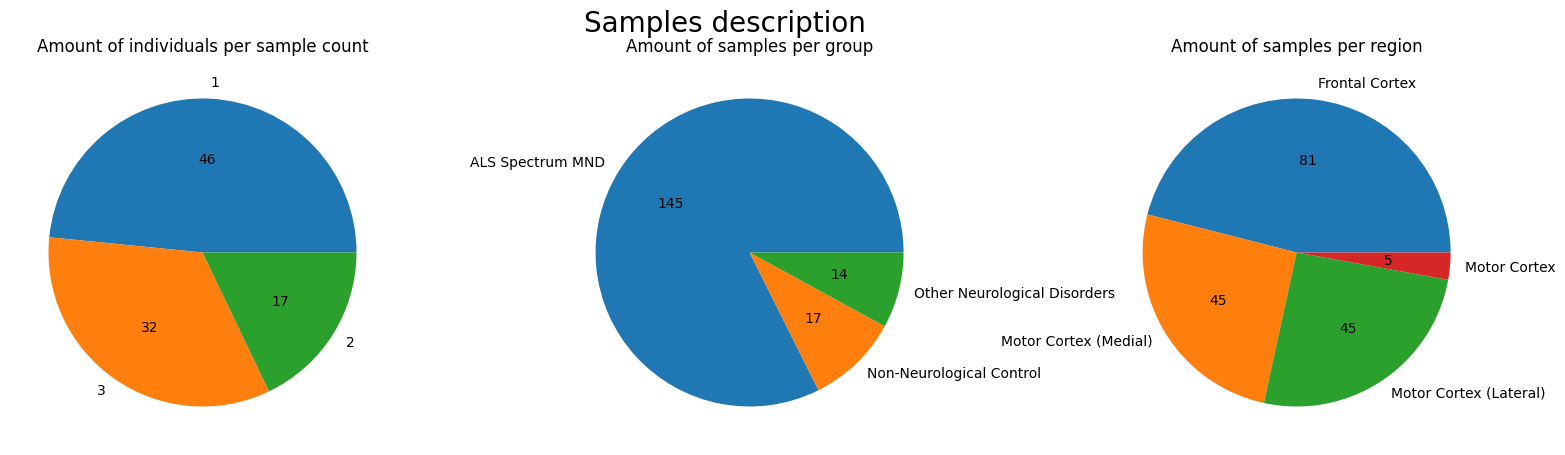

In [252]:
sequences.plot_annotations()

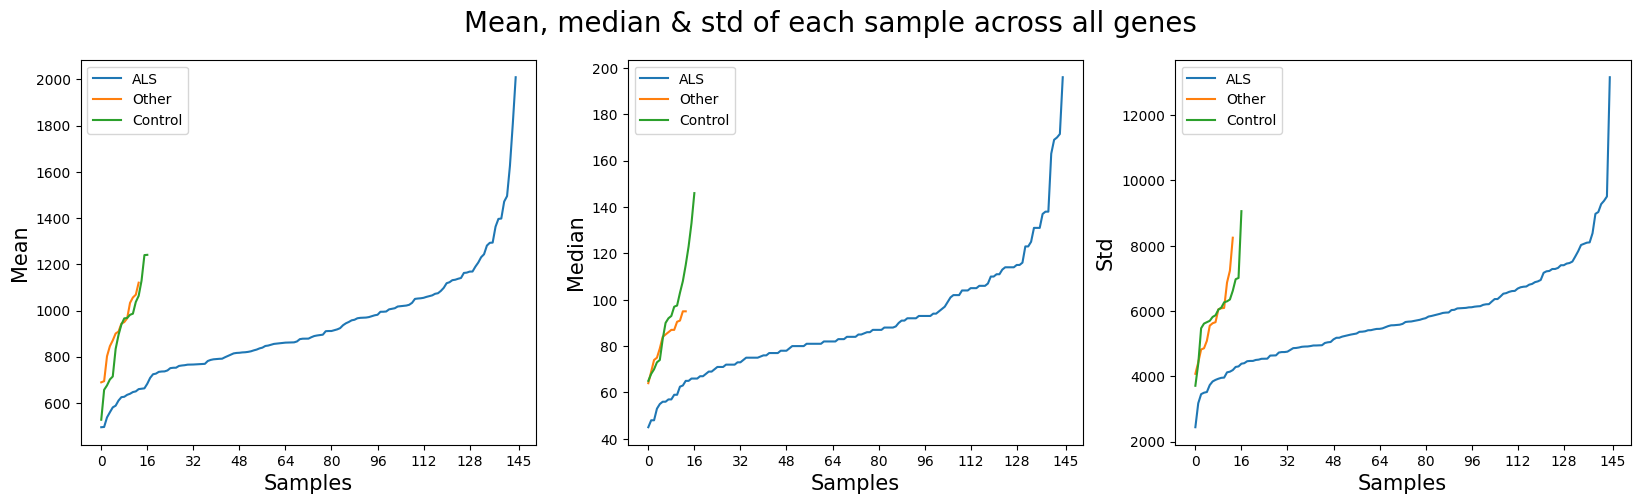

In [275]:
sequences.plot_metrics(by_sample=True)

### RNA counts description

In [276]:
rna_counts = sequences.get_rna_counts()
rna_counts.sample(n=10)

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,A4GALT,A4GNT,...,X6B_LINE:CR1:LINE,X7A_LINE:CR1:LINE,X7B_LINE:CR1:LINE,X7C_LINE:CR1:LINE,X7D_LINE:CR1:LINE,X8_LINE:CR1:LINE,X9_LINE:L1:LINE,Zaphod2:hAT-Tip100:DNA,Zaphod3:hAT-Tip100:DNA,Zaphod:hAT-Tip100:DNA
GSM3533348,51,145,0,1372,93,77,0,4,25,2,...,610,1466,1271,697,80,430,88,292,1192,1317
GSM3533250,35,141,0,5349,96,181,4,3,35,1,...,1072,2254,2113,1096,129,607,158,598,2067,2295
GSM3533356,24,108,0,997,129,122,3,1,14,0,...,1327,2536,2351,1215,101,668,147,681,2214,2742
GSM3533403,64,290,0,4752,118,174,8,2,135,0,...,623,1466,1246,726,61,358,107,347,1284,1469
GSM3533293,38,166,0,5970,190,153,0,0,129,1,...,980,1951,1968,976,101,466,129,549,1618,2049
GSM3533312,32,99,0,2523,71,197,3,3,14,2,...,563,1160,1214,591,55,304,75,316,862,1099
GSM3533287,21,130,0,2861,93,78,2,2,64,1,...,585,1349,1268,645,78,369,82,310,1272,1352
GSM3533285,37,136,0,2595,88,162,0,1,26,0,...,1032,2523,2216,1399,131,717,183,605,2275,2280
GSM3533320,66,114,0,3018,100,73,3,2,44,1,...,720,1507,1446,779,88,397,92,292,1286,1365
GSM3533390,30,85,0,1670,78,245,3,0,34,0,...,712,1641,1515,868,70,410,106,318,1286,1436


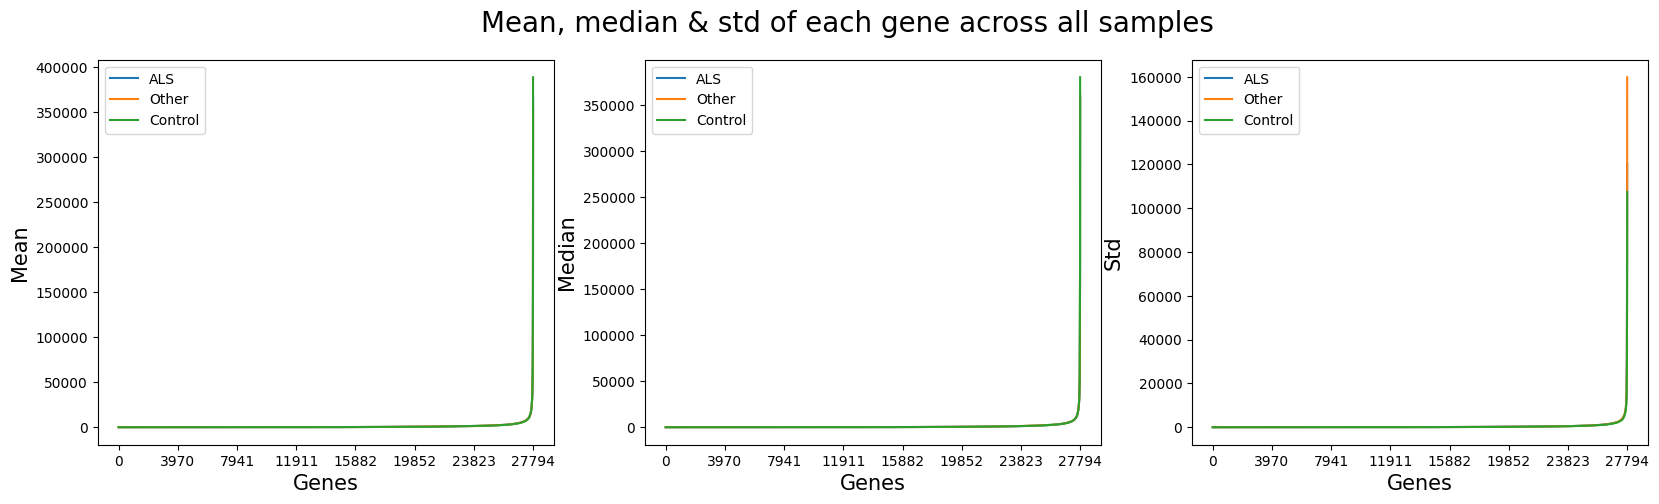

In [277]:
sequences.plot_metrics()

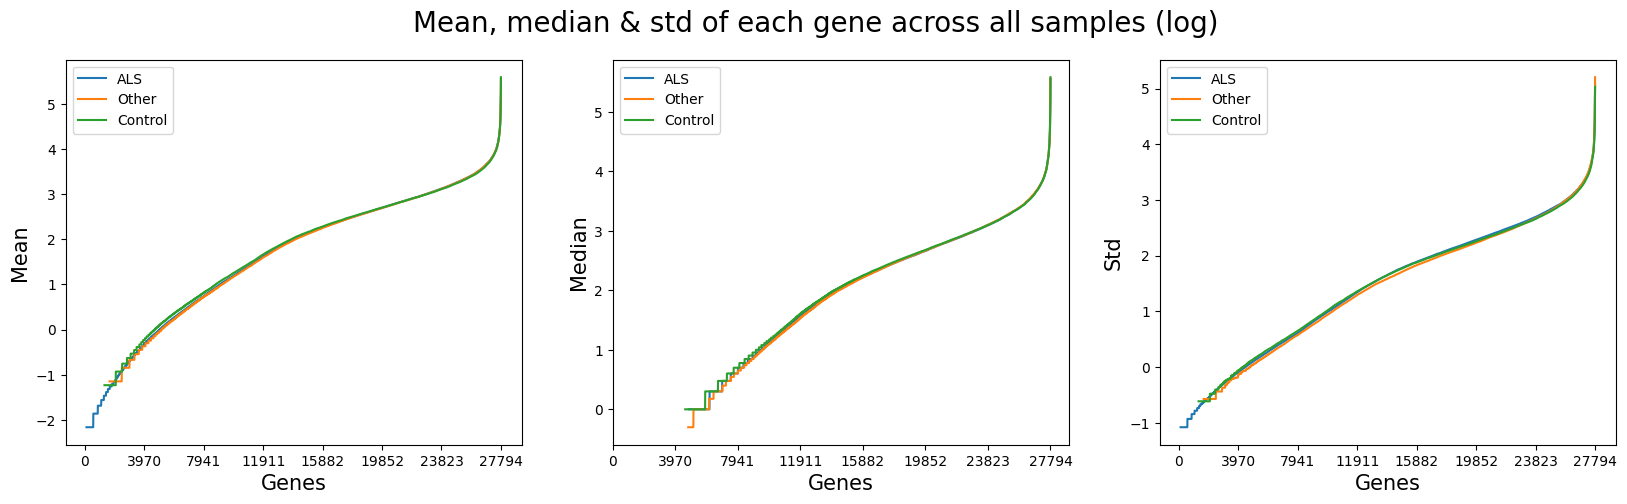

In [287]:
sequences.plot_metrics(log=True)

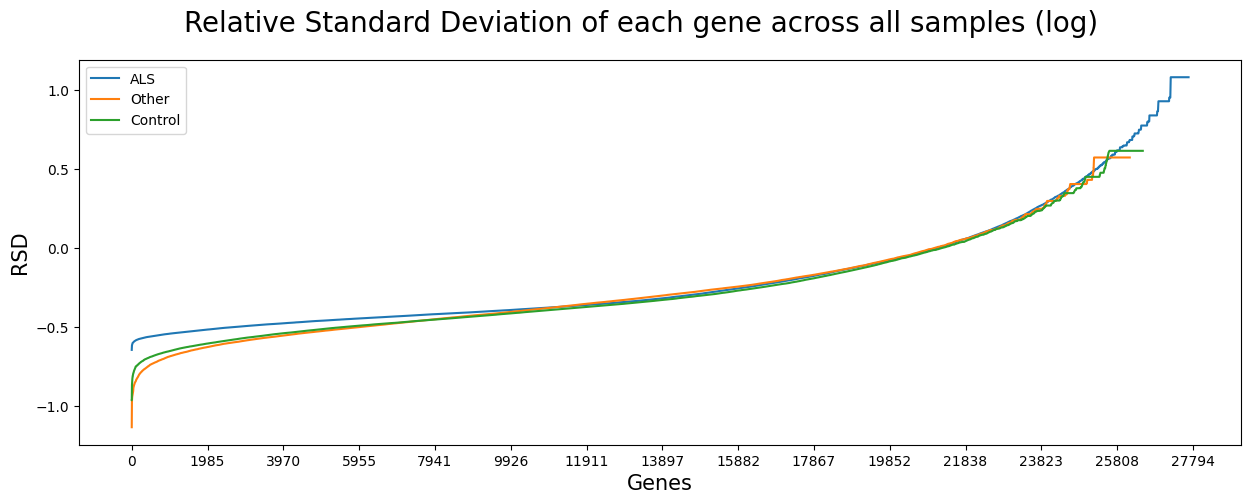

In [288]:
sequences.plot_rsd()

## Step 3 - PCA

In [337]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(rna_counts)
pca = PCA(n_components=0.95)
pca.fit(scaled_data)
pca_data = pca.transform(scaled_data)

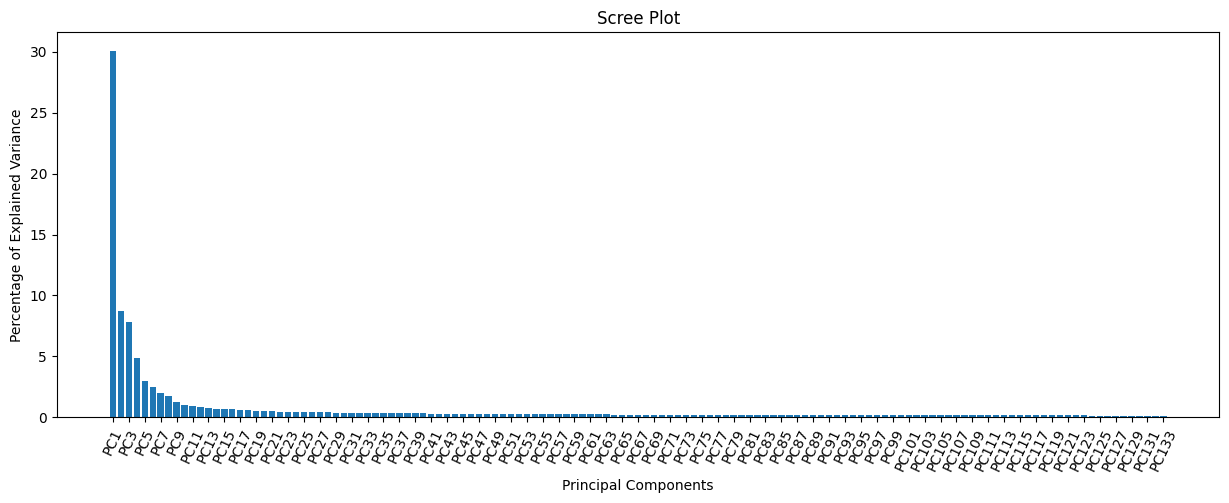

In [338]:
per_var = np.round(pca.explained_variance_ratio_ * 100, decimals=2)
labels = ["PC" + str(x) for x in range(1, len(per_var)+1, 2)]

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.bar(x=range(1,len(per_var)+1), height=per_var)
ax.set_xticks(np.arange(len(per_var), step=2) + 1)
ax.set_xticklabels(labels, rotation=65)
ax.set_ylabel("Percentage of Explained Variance")
ax.set_xlabel("Principal Components")
ax.set_title("Scree Plot")
plt.show()
plt.close()

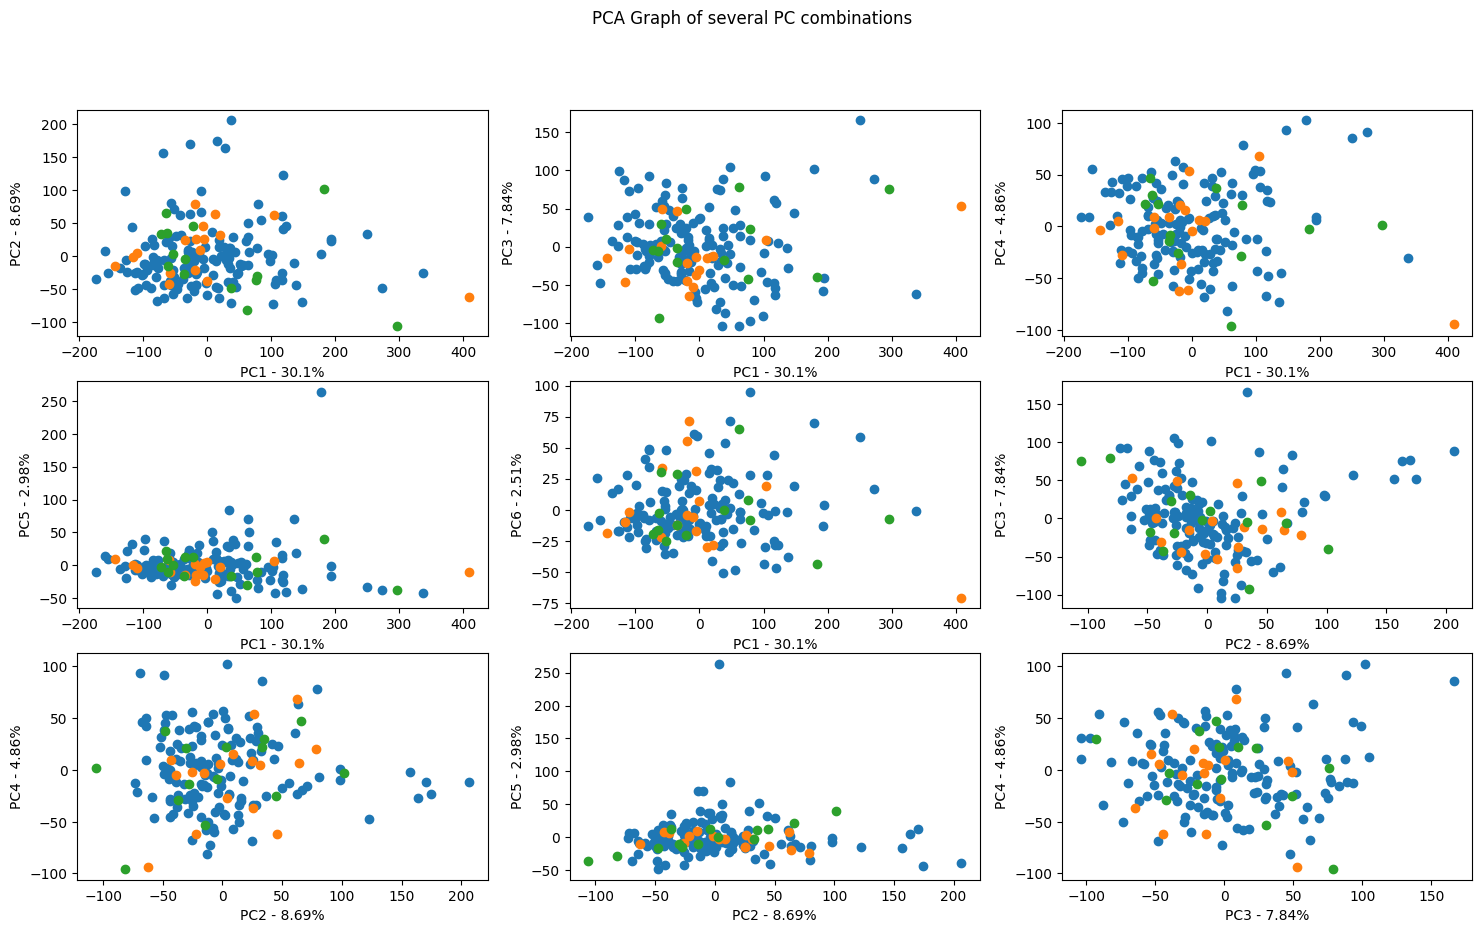

In [339]:
labels = ["PC" + str(x) for x in range(1, len(per_var)+1)]
pca_df = pd.DataFrame(pca_data, index=rna_counts.index, columns=labels)

fig, axes = plt.subplots(3, 3, figsize=(18, 10))
[[ax1, ax2, ax3], [ax4, ax5, ax6], [ax7, ax8, ax9]] = axes

pc_labels = {n+1: per_var[n] for n in range(7)}

bounds = np.concatenate([[0], sequences.groups_size(cumulative=True)])
for i in range(len(bounds)-1):
    pc =  {n+1: pca_df["PC"+str(n+1)][bounds[i]:bounds[i+1]] for n in range(7)}
    
    def make_label(axe, n, m):
        axe.scatter(pc[n], pc[m])
        axe.set_xlabel(f"PC{n} - {pc_labels[n]}%")
        axe.set_ylabel(f"PC{m} - {pc_labels[m]}%")

    make_label(ax1, 1, 2)
    make_label(ax2, 1, 3)
    make_label(ax3, 1, 4)
    make_label(ax4, 1, 5)
    make_label(ax5, 1, 6)
    make_label(ax6, 2, 3)
    make_label(ax7, 2, 4)
    make_label(ax8, 2, 5)
    make_label(ax9, 3, 4)

fig.suptitle("PCA Graph of several PC combinations")

#for sample in pca_df.index:
#    if pca_df.PC1.loc[sample] > pc1.median() + 3*pc1.std() or pca_df.PC2.loc[sample] > pc2.median() + 3*pc2.std():
#        axes[0][0].annotate(sample, (pca_df.PC1.loc[sample], pca_df.PC2.loc[sample]))

plt.show()
plt.close()

In [439]:
loading_scores = pd.Series(pca.components_[0], index=rna_counts.columns)
sorted_loading_scores = loading_scores.abs().sort_values(ascending=False)
top_10_genes = sorted_loading_scores[0:10].index.values

loading_scores[top_10_genes]

FAF2      0.010539
RPRD1B    0.010487
SUPT7L    0.010480
CHD6      0.010476
USP4      0.010475
DCAF5     0.010462
N4BP1     0.010454
NSD2      0.010444
PSMF1     0.010437
RER1      0.010432
dtype: float64

## Step 5 - Univariate analysis

In [445]:
als_index = annotations["Sample Group"] == "ALS Spectrum MND"
ctrl_index = annotations["Sample Group"] == "Non-Neurological Control"

p_values = rna_counts.apply(lambda x: ttest_ind(x[als_index.values], x[ctrl_index.values]).pvalue).fillna(1)

In [446]:
rejected, q_values, _, _ = multipletests(p_values.values, method="fdr_bh")

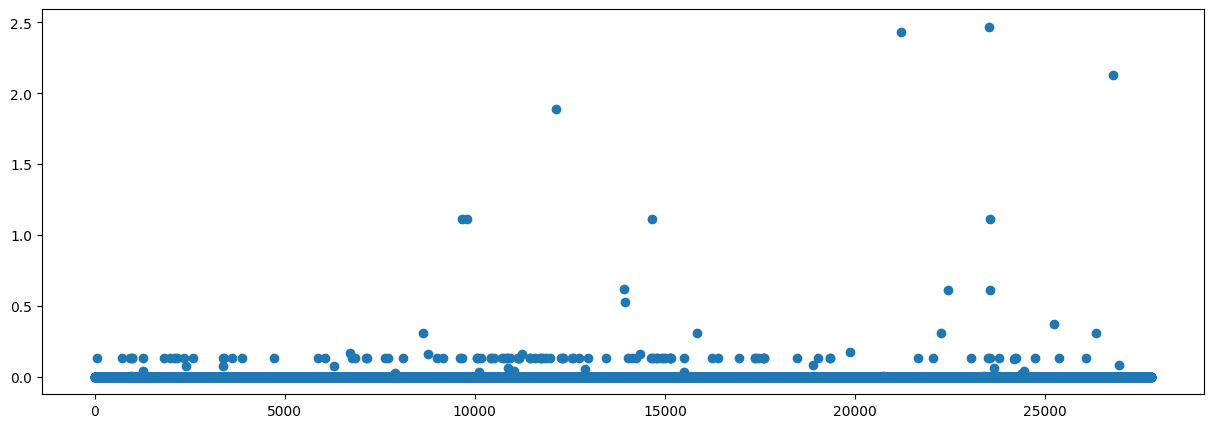

In [447]:
y_values = -np.log10(q_values)
x_values = np.arange(27794) + 1

fig, ax = plt.subplots(1, 1, figsize=(15, 5))

ax.scatter(x_values, y_values)

plt.show()
plt.close()